In [1]:
pwd

'g:\\Shared drives\\code\\projects\\pcmo\\notebooks'

# imports

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['font.size'] = 16
import xarray as xr
import sys
from tqdm.notebook import tqdm
from time import time
from glob import glob
from os.path import exists
import h5py
from skbeam.core import correlation as corr

from scipy.ndimage import gaussian_filter
from lmfit import Model, Parameter

In [3]:
from lmfit.lineshapes import lorentzian
# https://lmfit.github.io/lmfit-py/examples/example_two_dimensional_peak.html
def lorentzian2d(x, y, amplitude=1., centerx=0., centery=0., sigmax=1., sigmay=1.,
                 rotation=0, offset = 0):
    """Return a two dimensional lorentzian.

    The maximum of the peak occurs at ``centerx`` and ``centery``
    with widths ``sigmax`` and ``sigmay`` in the x and y directions
    respectively. The peak can be rotated by choosing the value of ``rotation``
    in radians.
    """
    xp = (x - centerx)*np.cos(rotation) - (y - centery)*np.sin(rotation)
    yp = (x - centerx)*np.sin(rotation) + (y - centery)*np.cos(rotation)
    R = (xp/sigmax)**2 + (yp/sigmay)**2

    return 2*amplitude*lorentzian(R)/(np.pi*sigmax*sigmay) + offset

# load single image, determine ROI and labels

In [4]:
temp = 230
file = rf'../data\4-4-2024\{temp:.0f}k_xpcs_1.h5'

roi = np.s_[150:1000, 1100:1900]
with h5py.File(file, 'r') as f:
    img = f['entry']['data']['data'][(0, *roi)]

img.shape

(850, 800)

In [7]:
with h5py.File(file, 'r') as f:
    print(f['entry1']['instrument_1']['detector_1']['data'].shape)

(1, 2000, 2048, 2048)


In [8]:
# 238 K
file = rf'../data\4-4-2024\238K_3s_exp_71d304f1-38ae-4e86-8a9b-db304a052c59.h5/'

roi = np.s_[150:1000, 1100:1900]
with h5py.File(file, 'r') as f:
    img = f['entry1']['instrument_1']['detector_1']['data'][(0, 0, *roi)]

img.shape

(850, 800)

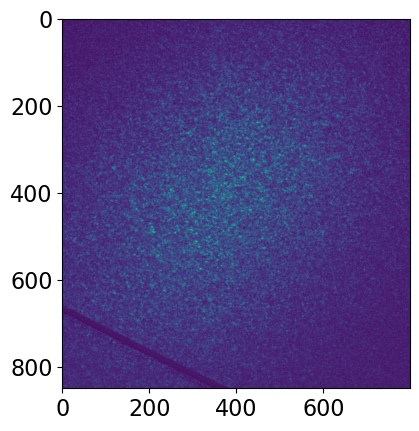

In [5]:
plt.imshow(img)

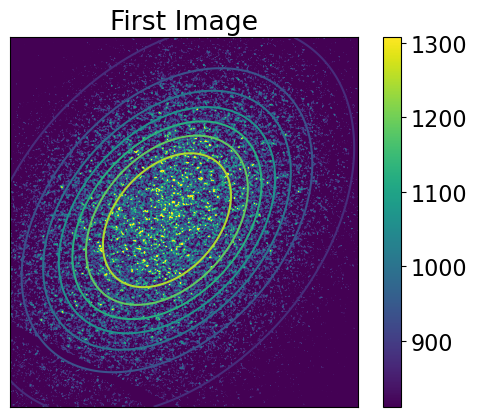

In [6]:
gimg = gaussian_filter(img, 35)
x, y = np.indices(gimg.shape)
mod = Model(lorentzian2d, independent_vars=['x', 'y'])
params = mod.make_params(amplitude=1e7)
params['amplitude'].set(value=1e7, min=1e6, max=1e9)
params['rotation'].set(value=0.75, min=0.5, max=1)
params['sigmax'].set(value=165, min=150, max=300)
params['sigmay'].set(value=150, min=100, max=200)
params['centery'].set(value=365, min=300, max=400)
params['centerx'].set(value=425, min=400, max=500)
params['offset'].set(value=200, min=150, max=1000)

error = 1 / np.sqrt(gimg).ravel()
result = mod.fit(img.ravel(), x=x.ravel(), y=y.ravel(), params=params, weights=1/error)
fit = mod.func(x, y, **result.best_values)


plt.figure()
plt.imshow(img, vmin=np.percentile(img, 50), vmax=np.percentile(img, 99.5))
plt.colorbar()
plt.contour(fit)
plt.xticks([])
plt.yticks([])
plt.title('First Image')
plt.show()

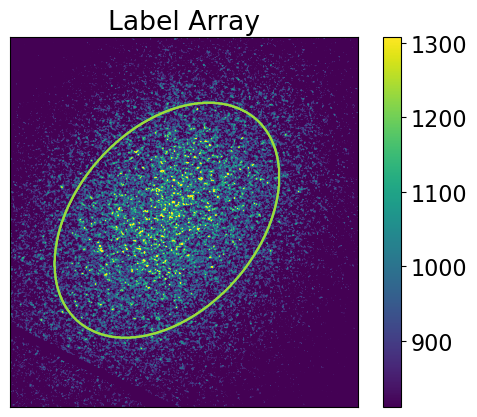

In [7]:
label_array = np.zeros_like(img)
label_array[fit>np.percentile(fit, 70)] = 1

plt.figure()
plt.imshow(img, vmin=np.percentile(img, 50), vmax=np.percentile(img, 99.5))
plt.colorbar()
plt.contour(label_array)
plt.xticks([])
plt.yticks([])
plt.title('Label Array')
plt.show()

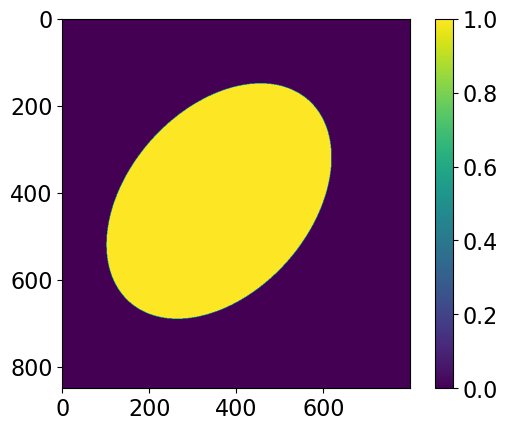

In [8]:
plt.imshow(label_array)
plt.colorbar()
plt.show()

# load all images

In [9]:
with h5py.File(file, 'r') as f:
    imgs = f['entry']['data']['data'][(..., *roi)].astype(float)

In [18]:
# 238 K

with h5py.File(file, 'r') as f:
    imgs = np.squeeze(f['entry1']['instrument_1']['detector_1']['data'][(..., *roi)]).astype(float)

In [10]:
imgs /= np.expand_dims(imgs.mean(axis=(1,2)), axis=(1,2))

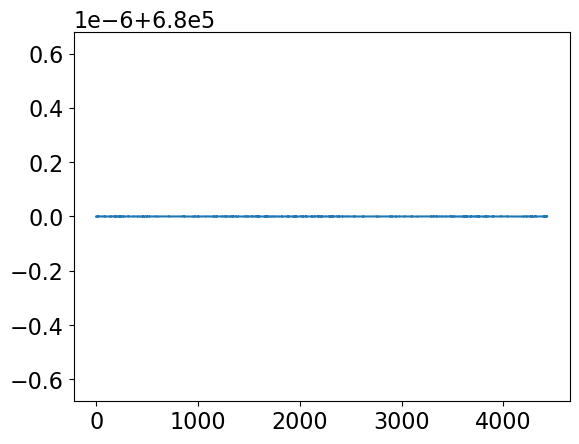

In [11]:
plt.figure()
plt.plot(imgs.sum(axis=(1,2)))
plt.show()

# calculate two time

In [12]:
imgs.shape

(4430, 850, 800)

In [ ]:
imgs = imgs[:844]

In [13]:
num_bufs = imgs.shape[0]
num_frames = num_bufs
num_levels = 1

gen = corr.lazy_two_time(label_array, imgs[:num_frames], num_frames, num_bufs, num_levels)
for result in tqdm(gen, total=len(imgs)):
    pass
out = corr.two_time_state_to_results(result)
g2_2t, lag_steps_2t = np.squeeze(out.g2), out.lag_steps

  0%|          | 0/4430 [00:00<?, ?it/s]

In [14]:
g2_2t.shape

(4430, 4430)

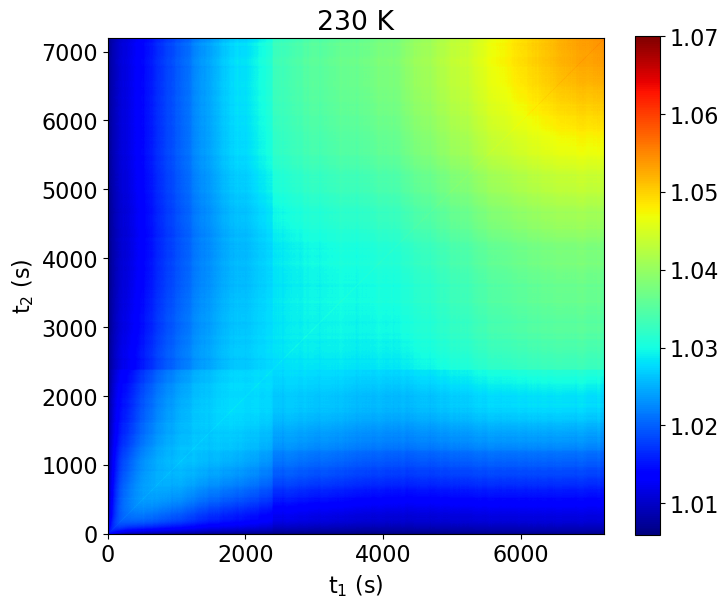

In [18]:
temp = 230
plt.figure(figsize=(8,8))
plt.title(f'{temp} K')
plt.imshow(g2_2t, origin='lower', cmap='jet', vmax=1.07,
           extent=[0, len(g2_2t)*1.625, 0, len(g2_2t)*1.625])
plt.colorbar(shrink=0.81)
plt.xlabel(r't$_1$ (s)')
plt.ylabel(r't$_2$ (s)')
plt.show()

In [16]:
np.save(f'../data/4-4-2024/230k_two_hour_twotime_intensity_normalized.npy', g2_2t)

In [28]:
np.save(f'../data/4-4-2024/{temp:.0f}_twotime_intensity_normalized.npy', g2_2t)